# QSVM aplicado a um database de manutenção

Elaborado por:
- Equipe Qast - Beer Quantum Challenge (Ambev+QB) 2021

Nos notebooks anteriores:

- Estudamos "casos extremos" do uso do QSVM comparado ao SVM

Porém, os dados utilizados eram sintéticos

Neste notebook:

- Vamos utilizar o QSVM com um database de manutenção preventiva, retirado de https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

### 1. Importar bilbiotecas 

In [1]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer, IBMQ
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

#scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.svm as svm
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels import QuantumKernel

### 2. Carregar dados

In [2]:
df = pd.read_csv('ai4i2020.csv')

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [3]:
#Somente parte vai ser utilizada, por limitações da simulação. Vamos aproveitar então para construir um database equilibrado
dffailure = df[df['Machine failure'] == 1].sample(100)

dfworking = df[df['Machine failure'] != 1].sample(100)

df = pd.concat([dffailure, dfworking], axis = 0)

df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
4755,4756,L51935,L,303.4,311.7,1295,51.3,51,1,0,1,0,0,0
6340,6341,H35754,H,300.5,309.9,1397,45.9,210,1,1,0,0,0,0
380,381,L47560,L,297.5,308.3,2564,12.8,127,1,0,0,1,0,0
194,195,M15054,M,298.2,308.5,2678,10.7,86,1,0,0,1,0,0
4130,4131,L51310,L,301.9,310.4,1286,62.8,22,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,3261,M18120,M,301.3,310.0,2068,17.8,176,0,0,0,0,0,0
2057,2058,L49237,L,299.5,309.3,1520,42.3,149,0,0,0,0,0,0
8317,8318,L55497,L,298.7,309.7,1667,30.4,92,0,0,0,0,0,0
6002,6003,L53182,L,300.5,310.3,1683,31.5,8,0,0,0,0,0,0


### 3. Preparar features

In [ ]:
dic = {'L' : -1, 'M' : 0, 'H'  : 1}

df['TypeNum'] = df['Type'].apply(lambda x : dic[x])

In [5]:
features_labels = ['TypeNum', 'Air temperature [K]',
    'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
    'Tool wear [min]']
    
target_label = ['Machine failure']

df = df[features_labels + target_label]

### 4. separar e padronizar dados

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[features_labels], df[target_label], test_size=0.2, random_state=42)

#8000 for training, 2000 for testing

In [20]:
# Standardize
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

# 5 Quantum SVM - simulação

In [21]:
backend = Aer.get_backend('statevector_simulator')
feature_map = ZFeatureMap(feature_dimension=6, reps = 1)

In [22]:
QKernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

Exemplo do circuito paramétrico escolhido

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


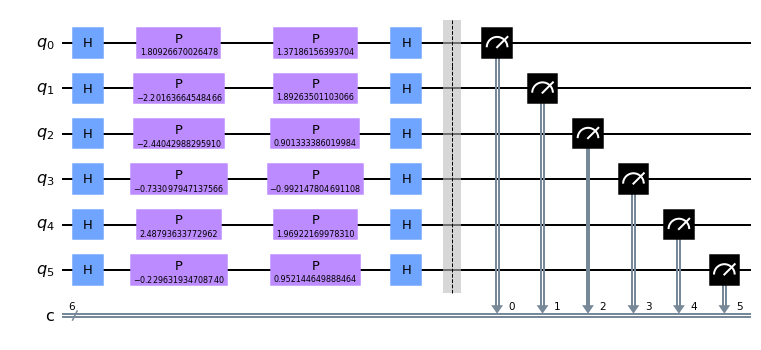

In [23]:
QKernel.construct_circuit(Xtrain[0], Xtrain[1]).decompose().decompose().draw(output= 'mpl')

In [24]:
matrix_train = QKernel.evaluate(x_vec=Xtrain)
matrix_test = QKernel.evaluate(x_vec=Xtest, y_vec=Xtrain)

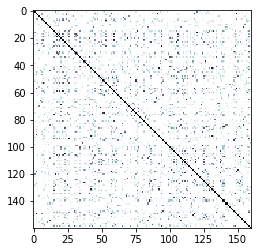

In [25]:
#matrix kernel
img = plt.imshow(np.asmatrix(matrix_train), interpolation = 'nearest', origin='upper', cmap = 'bone_r')

In [26]:
qsvc = svm.SVC(kernel='precomputed')
qsvc.fit(matrix_train, ytrain)
quantum_score = qsvc.score(matrix_test, ytest)

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
quantum_score

0.925

$\textbf{Conclusão}$: a performance do qsvm é muito boa no espaço de teste! Como usamos um circuito simples (pequeno e sem necessidade de CNOTs), e com poucos qubits, acreditamos que conseguiríamos um bom score até mesmo em um dispositivo NISQ. Porém, não conseguimos verificá-lo em hardware quântico real pois o qiskit quebra a aproximação do kernel em um job por entrada da matriz (totalizando 25, com PCA para 5 dimensões). Só podemos enviar até 5 jobs ao mesmo, e a fila para um único job pode demorar horas. 

Observamos o potencial do QSVM para um database (simplificado) de natureza semelhante à aplicação proposta